Supervised Text Classification Problem
To investigate which supervised machine learning methods best suited to solve this
Given new complaint incoming, how do we assign it to one of 12 categories


In [5]:
import pandas as pd
df = pd.read_csv('complaints.csv')
df['date'] = pd.to_datetime(df['Date received'])

df = df[~(df['date'] < '2022-03-01')]
df.head()

C:\Users\hrxta\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,date
0,2022-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",LA,70811,NaN,NaN,Web,2022-06-13,In progress,Yes,NaN,5663657,2022-06-13
1,2022-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Billing dispute for services,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,76302,NaN,NaN,Web,2022-06-13,In progress,Yes,NaN,5663734,2022-06-13
2,2022-06-12,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",OK,74008,NaN,NaN,Web,2022-06-12,In progress,Yes,NaN,5660360,2022-06-12
3,2022-06-05,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,In accordance with the Fair Credit Reporting a...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,PA,19473,NaN,Consent provided,Web,2022-06-05,Closed with explanation,Yes,NaN,5635230,2022-06-05
4,2022-06-07,Mortgage,VA mortgage,Applying for a mortgage or refinancing an exis...,NaN,NaN,NaN,"PENNYMAC LOAN SERVICES, LLC.",NC,27597,Servicemember,NaN,Web,2022-06-07,Closed with explanation,Yes,NaN,5640197,2022-06-07


In [7]:
df.count()

Date received                   211446
Product                         211446
Sub-product                     211446
Issue                           211446
Sub-issue                       199003
Consumer complaint narrative     50805
Company public response          85984
Company                         211446
State                           210617
ZIP code                        210580
Tags                             18175
Consumer consent provided?      119152
Submitted via                   211446
Date sent to company            211446
Company response to consumer    211446
Timely response?                211446
Consumer disputed?                   0
Complaint ID                    211446
date                            211446
dtype: int64

In [8]:
from io import StringIO
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]

# Remove missing values in “Consumer complaints narrative” column, 
# and add a column encoding the product as an integer because categorical variables
# are often better represented by integers than strings
# We also create a couple of dictionaries for future use

df.columns = ['Product', 'Consumer_complaint_narrative']

df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product',
'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id','Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
3,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...,0
7,Mortgage,The mortgage bank has not been crediting my VA...,1
31,Debt collection,XXXX XXXX never sent information to verify debt,2
43,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting A...,0
48,"Credit reporting, credit repair services, or o...",Over the course of 30 days I have filed a disp...,0


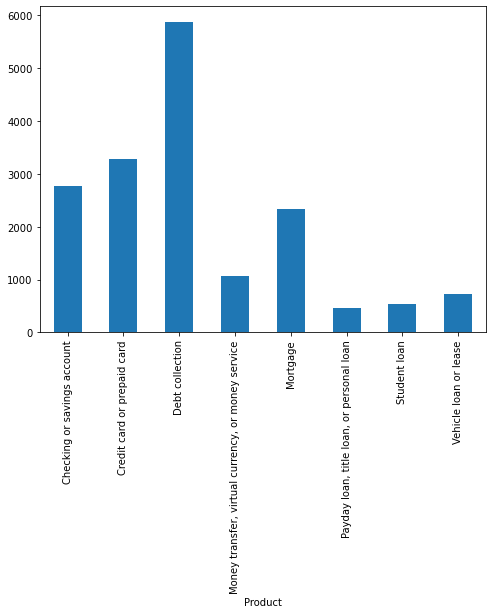

In [11]:
import matplotlib.pyplot as plt

df = df[df["Product"].str.contains("Credit reporting, credit repair services, or other personal consumer reports") == False]

fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. 
For some cases, such as fraud detection or cancer prediction, we would need to carefully configure our model or artificially balance the dataset, for example by undersampling or oversampling each class.

This case of learning imbalanced data, the majority classes might be of our greater interest. 

Classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes possible

The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Requires preprocessing.

Using bar of words, model for each text description, presence and frequency of words is taken into consideration, but ignores order.

Shall measure term called Term frequency, Inverse document frequency -> tf-idf
Use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives

*sublinear_df is set to True to use a logarithmic form for frequency.
*min_df is the minimum numbers of documents a word must be present in to be kept.
*norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
*ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
*stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorize format saved to a variable
tfidf = TfidfVectorizer(sublinear_tf =True, min_df=5, norm='l2',
encoding='latin-1', ngram_range=(1,2), stop_words='english')

features= tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(17038, 52125)

In [18]:
from sklearn.feature_selection import chi2
import numpy as np
# use chi2 to find terms that are most correlated with each of the product categories

N=2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


# 'Checking or savings account':
  . Most correlated unigrams:
. bank
. checking
  . Most correlated bigrams:
. debit card
. checking account
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. synchrony
. card
  . Most correlated bigrams:
. credit limit
. credit card
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. documentations
. documented
  . Most correlated bigrams:
. documentation told
. zwicker associates
# 'Debt collection':
  . Most correlated unigrams:
. collection
. debt
  . Most correlated bigrams:
. identity theft
. credit report
# 'Money transfer, virtual currency, or money service':
  . Most correlated unigrams:
. coinbase
. paypal
  . Most correlated bigrams:
. cash app
. paypal account
# 'Mortgage':
  . Most correlated unigrams:
. escrow
. mortgage
  . Most correlated bigrams:
. loan modification
. mortgage company
# 'Payday loan, title loan, or personal loan':
  . Most correlated unigrams:


KeyboardInterrupt: 

Multi-Class Classifier: Features and Design
To train supervised classifiers, we first transformed the “Consumer complaint narrative” into a vector of numbers. 
We explored vector representations such as TF-IDF weighted vectors.
After having this vector representations of the text we can train supervised classifiers to train unseen “Consumer complaint narrative” and predict the “product” on which they fall.

In [19]:
# Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

x_train, x_test, y_train, y_test = train_test_split(
    df['Consumer_complaint_narrative'],df['Product'], random_state=0
)
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train)
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

clf = MultinomialNB().fit(x_train_tfidf, y_train)

In [22]:
print(clf.predict(count_vect.transform(
    ['Credit card']
    )))

['Credit card or prepaid card']


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

KeyboardInterrupt: 